## ARIMA vs LSTM


### Multi step LSTM



In [ ]:
# RNN - LSTM for time-series forecasting
# partly follows blog https://machinelearningmastery.com/introduction-to-time-series-forecasting-with-python/

from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot as plt
from numpy import array

# trajectory matrix for solving supervized learning task
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # output sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

interval = 365
# diffential series interval
def difference(dataset, interval=interval):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)


# train / test splitting
def prepare_data(series, n_test, n_lag, n_seq):
    raw_values = series.values
    diff_series = difference(raw_values, interval)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test


# fit an LSTM network
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()

    # stateful = True - keep state in memory;
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history_loss=[]
    history_val_loss=[]
    for i in range(nb_epoch):
        print(i)
        hist = model.fit(X, y, validation_split=0.1,epochs=1, batch_size=n_batch, verbose=1, shuffle=True)
        history_loss.append(hist.history['loss'])
        history_val_loss.append(hist.history['val_loss'])
    print(model.summary())
    return model,history_loss,history_val_loss

# 1 step of forecasting
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]

# Forecasting
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

# inverse difference
def inverse_difference(history, forecast):
    # invert first forecast
    inverted = list()
    last_val = list()
    for i,last_ob in enumerate(history):
      inverted.append(forecast[i] + last_ob)
      last_val.append(last_ob)

    # propagate difference forecast using inverted first value
    for j in range(i,len(forecast)):
        inverted.append(forecast[j] + inverted[j-interval])
        last_val.append(inverted[j-interval])
   # plt.plot(last_val)
    #plt.show()
    return inverted

# inverse transformation
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
    # create array from forecast
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
       # plt.plot(inv_scale)
       # plt.plot()
        # invert differencing
        index = len(series) - n_test + i - interval
        last_ob = series.values[index:]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store


        inverted.append(inv_diff)
    return inverted



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  import sys


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


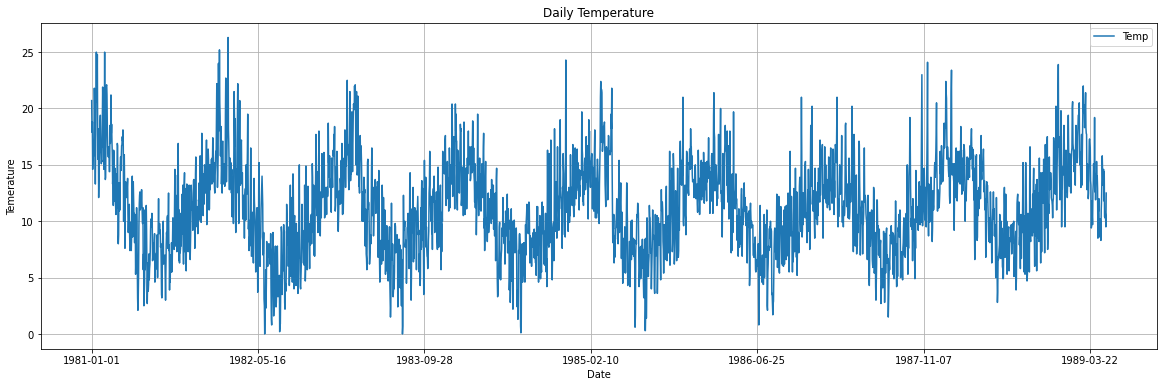

In [ ]:
# Data
data = pd.read_csv("/content/drive/My Drive/HW_AdvancedML/SMLT_ITMO_01/daily_temp.csv", dayfirst=True)[:-600]
data.plot(x='Date', y='Temp', figsize =  (20, 6), grid = True, ylabel = "Temerature", title = "Daily Temperature")

In [ ]:
next_values =  pd.read_csv("/content/drive/My Drive/HW_AdvancedML/SMLT_ITMO_01/daily_temp.csv", dayfirst=True)[-600:]

In [ ]:
data['meanTemp'] = data['Temp'] - data['Temp'].rolling(10).mean()

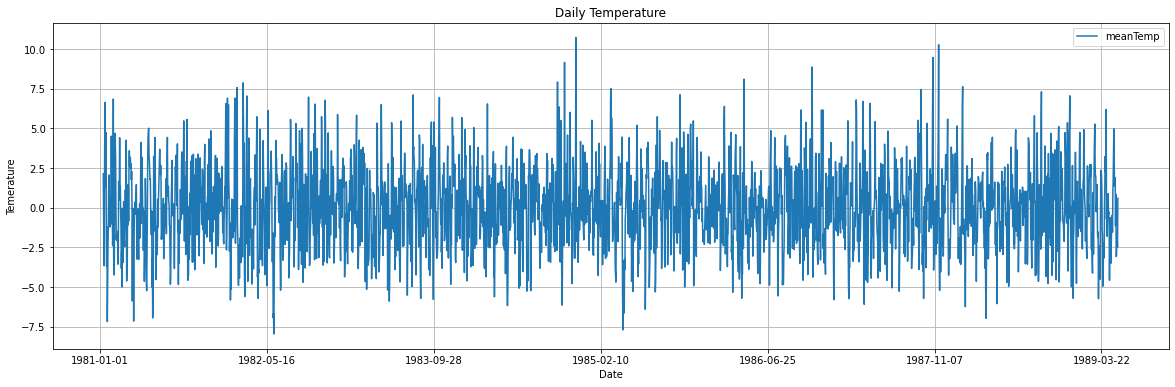

In [ ]:
data.plot(x='Date', y='meanTemp', figsize =  (20, 6), grid = True, ylabel = "Temerature", title = "Daily Temperature")

In [ ]:
# trajectory matrix

d1 = series_to_supervised(data, n_in=5, n_out=7, dropnan=True)
d1

,var1(t-5),var2(t-5),var3(t-5),var1(t-4),var2(t-4),var3(t-4),var1(t-3),var2(t-3),var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t),var1(t+1),var2(t+1),var3(t+1),var1(t+2),var2(t+2),var3(t+2),var1(t+3),var2(t+3),var3(t+3),var1(t+4),var2(t+4),var3(t+4),var1(t+5),var2(t+5),var3(t+5),var1(t+6),var2(t+6),var3(t+6)
14,1981-01-10,20.0,2.14,1981-01-11,16.2,-1.21,1981-01-12,13.3,-3.65,1981-01-13,16.7,-0.04,1981-01-14,21.5,4.07,1981-01-15,25.0,6.65,1981-01-16,20.7,1.86,1981-01-17,20.6,1.28,1981-01-18,24.8,4.74,1981-01-19,17.7,-1.95,1981-01-20,15.5,-3.70,1981-01-21,18.2,-1.20
15,1981-01-11,16.2,-1.21,1981-01-12,13.3,-3.65,1981-01-13,16.7,-0.04,1981-01-14,21.5,4.07,1981-01-15,25.0,6.65,1981-01-16,20.7,1.86,1981-01-17,20.6,1.28,1981-01-18,24.8,4.74,1981-01-19,17.7,-1.95,1981-01-20,15.5,-3.70,1981-01-21,18.2,-1.20,1981-01-22,12.1,-7.18
16,1981-01-12,13.3,-3.65,1981-01-13,16.7,-0.04,1981-01-14,21.5,4.07,1981-01-15,25.0,6.65,1981-01-16,20.7,1.86,1981-01-17,20.6,1.28,1981-01-18,24.8,4.74,1981-01-19,17.7,-1.95,1981-01-20,15.5,-3.70,1981-01-21,18.2,-1.20,1981-01-22,12.1,-7.18,1981-01-23,14.4,-4.65
17,1981-01-13,16.7,-0.04,1981-01-14,21.5,4.07,1981-01-15,25.0,6.65,1981-01-16,20.7,1.86,1981-01-17,20.6,1.28,1981-01-18,24.8,4.74,1981-01-19,17.7,-1.95,1981-01-20,15.5,-3.70,1981-01-21,18.2,-1.20,1981-01-22,12.1,-7.18,1981-01-23,14.4,-4.65,1981-01-24,16.0,-2.50
18,1981-01-14,21.5,4.07,1981-01-15,25.0,6.65,1981-01-16,20.7,1.86,1981-01-17,20.6,1.28,1981-01-18,24.8,4.74,1981-01-19,17.7,-1.95,1981-01-20,15.5,-3.70,1981-01-21,18.2,-1.20,1981-01-22,12.1,-7.18,1981-01-23,14.4,-4.65,1981-01-24,16.0,-2.50,1981-01-25,16.5,-1.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3039,1989-04-25,11.0,0.92,1989-04-26,11.9,1.77,1989-04-27,14.0,3.56,1989-04-28,15.8,4.98,1989-04-29,14.5,3.09,1989-04-30,13.2,1.37,1989-05-01,14.2,1.91,1989-05-02,14.6,1.87,1989-05-03,11.8,-1.13,1989-05-04,14.4,0.86,1989-05-05,10.4,-3.08,1989-05-06,10.3,-3.02
3040,1989-04-26,11.9,1.77,1989-04-27,14.0,3.56,1989-04-28,15.8,4.98,1989-04-29,14.5,3.09,1989-04-30,13.2,1.37,1989-05-01,14.2,1.91,1989-05-02,14.6,1.87,1989-05-03,11.8,-1.13,1989-05-04,14.4,0.86,1989-05-05,10.4,-3.08,1989-05-06,10.3,-3.02,1989-05-07,10.8,-2.20
3041,1989-04-27,14.0,3.56,1989-04-28,15.8,4.98,1989-04-29,14.5,3.09,1989-04-30,13.2,1.37,1989-05-01,14.2,1.91,1989-05-02,14.6,1.87,1989-05-03,11.8,-1.13,1989-05-04,14.4,0.86,1989-05-05,10.4,-3.08,1989-05-06,10.3,-3.02,1989-05-07,10.8,-2.20,1989-05-08,10.5,-1.97
3042,1989-04-28,15.8,4.98,1989-04-29,14.5,3.09,1989-04-30,13.2,1.37,1989-05-01,14.2,1.91,1989-05-02,14.6,1.87,1989-05-03,11.8,-1.13,1989-05-04,14.4,0.86,1989-05-05,10.4,-3.08,1989-05-06,10.3,-3.02,1989-05-07,10.8,-2.20,1989-05-08,10.5,-1.97,1989-05-09,9.5,-2.47


In [ ]:
# hyperparameters initialization and training the model
import numpy as np

n_lag = 50
n_seq = 600
n_test = 1
n_epochs = 9
n_batch = 1
n_neurons =  256

scaler, train, test = prepare_data(data['Temp'], n_test, n_lag, n_seq)
model,history_loss,history_val_loss = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)



0
1831/1831 [==============================] - 7s 3ms/step - loss: 0.0829 - val_loss: 0.0839
1
1831/1831 [==============================] - 6s 3ms/step - loss: 0.0813 - val_loss: 0.0838
2
1831/1831 [==============================] - 6s 3ms/step - loss: 0.0805 - val_loss: 0.0842
3
1831/1831 [==============================] - 6s 3ms/step - loss: 0.0798 - val_loss: 0.0843
4
1831/1831 [==============================] - 6s 3ms/step - loss: 0.0789 - val_loss: 0.0850
5
1831/1831 [==============================] - 5s 3ms/step - loss: 0.0780 - val_loss: 0.0855
6
1831/1831 [==============================] - 6s 3ms/step - loss: 0.0769 - val_loss: 0.0860
7
1831/1831 [==============================] - 6s 3ms/step - loss: 0.0758 - val_loss: 0.0873
8
1831/1831 [==============================] - 6s 3ms/step - loss: 0.0746 - val_loss: 0.0880
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10

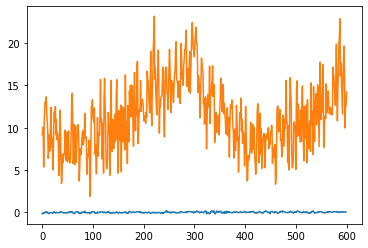

In [ ]:

forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
# print(np.mean(forecasts))
# forecasts = forecasts - np.mean(forecasts) + 0.14
plt.plot(forecasts[0])
forecasts = inverse_transform(data['Temp'], forecasts, scaler, n_test)
plt.plot(forecasts[0])

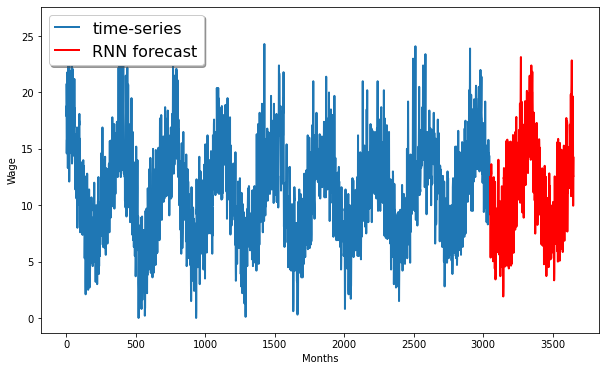

In [ ]:
# visualize

fig=plt.figure(figsize=(10,6))
plt.plot(data['Temp'][:],linewidth=2)
off_s = len(data) - n_test + len(forecasts) -1
off_e = off_s + len(forecasts[0]) + 1
xaxis = [x for x in range(off_s, off_e)]
yaxis = [data['Temp'][off_s]] + forecasts[-1]
plt.plot(xaxis, yaxis, color='r',linewidth=2)

plt.ylabel('Wage')
plt.xlabel('Months')

plt.legend(('time-series', 'RNN forecast'),
           shadow=True, loc='upper left', handlelength=1.5, fontsize=16)
plt.show()


In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error

MAPE:  0.35970515810307063
R squere:  0.18342331839553783


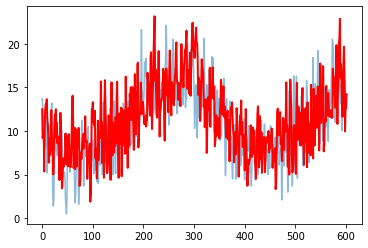

In [ ]:
plt.plot(next_values['Temp'].values, alpha = 0.5)
plt.plot(yaxis, color='r',linewidth=2)

print("MAPE: ", mean_absolute_percentage_error(next_values['Temp'].values,yaxis[:600]))
print("R squere: ", r2_score(next_values['Temp'].values,yaxis[:600]))

# ARIMA

Auto Regressive Integrated Moving Average, сокращенно ARIMA, представляет собой алгоритм прогнозирования, основанный на концепции, согласно которой данные предыдущих значений временного ряда могут использоваться только для прогнозирования будущих значений.

ARIMA — наивная модель, она предполагает, что данные временных рядов, с которыми мы работаем, удовлетворяют следующим условиям:


«несезонный» означает, что разные времена года не влияют на его значения. Когда существует сезонность, мы используем модель SARIMA, сокращенно от Seasonal ARIMA.


Нет нерегулярных событий. Пример: никаких нерегулярных событий, таких как Covid, которые влияют на наши данные.

### Гиперпараметры

p — порядок термина AR
Количество лагов Y для использования в качестве предикторов. Другими словами, если вы пытаетесь предсказать июньскую распродажу, сколько данных за предыдущий (лаг) месяц вы собираетесь использовать?

q — порядок термина MA
Количество запаздывающих ошибок прогноза -> сколько прошлых ошибок прогноза вы будете использовать?

d — Минимальный разностный период
Минимальное количество разностей, необходимых для того, чтобы сделать данные временных рядов стационарными.

Уже стационарные данные имели бы d = 0.


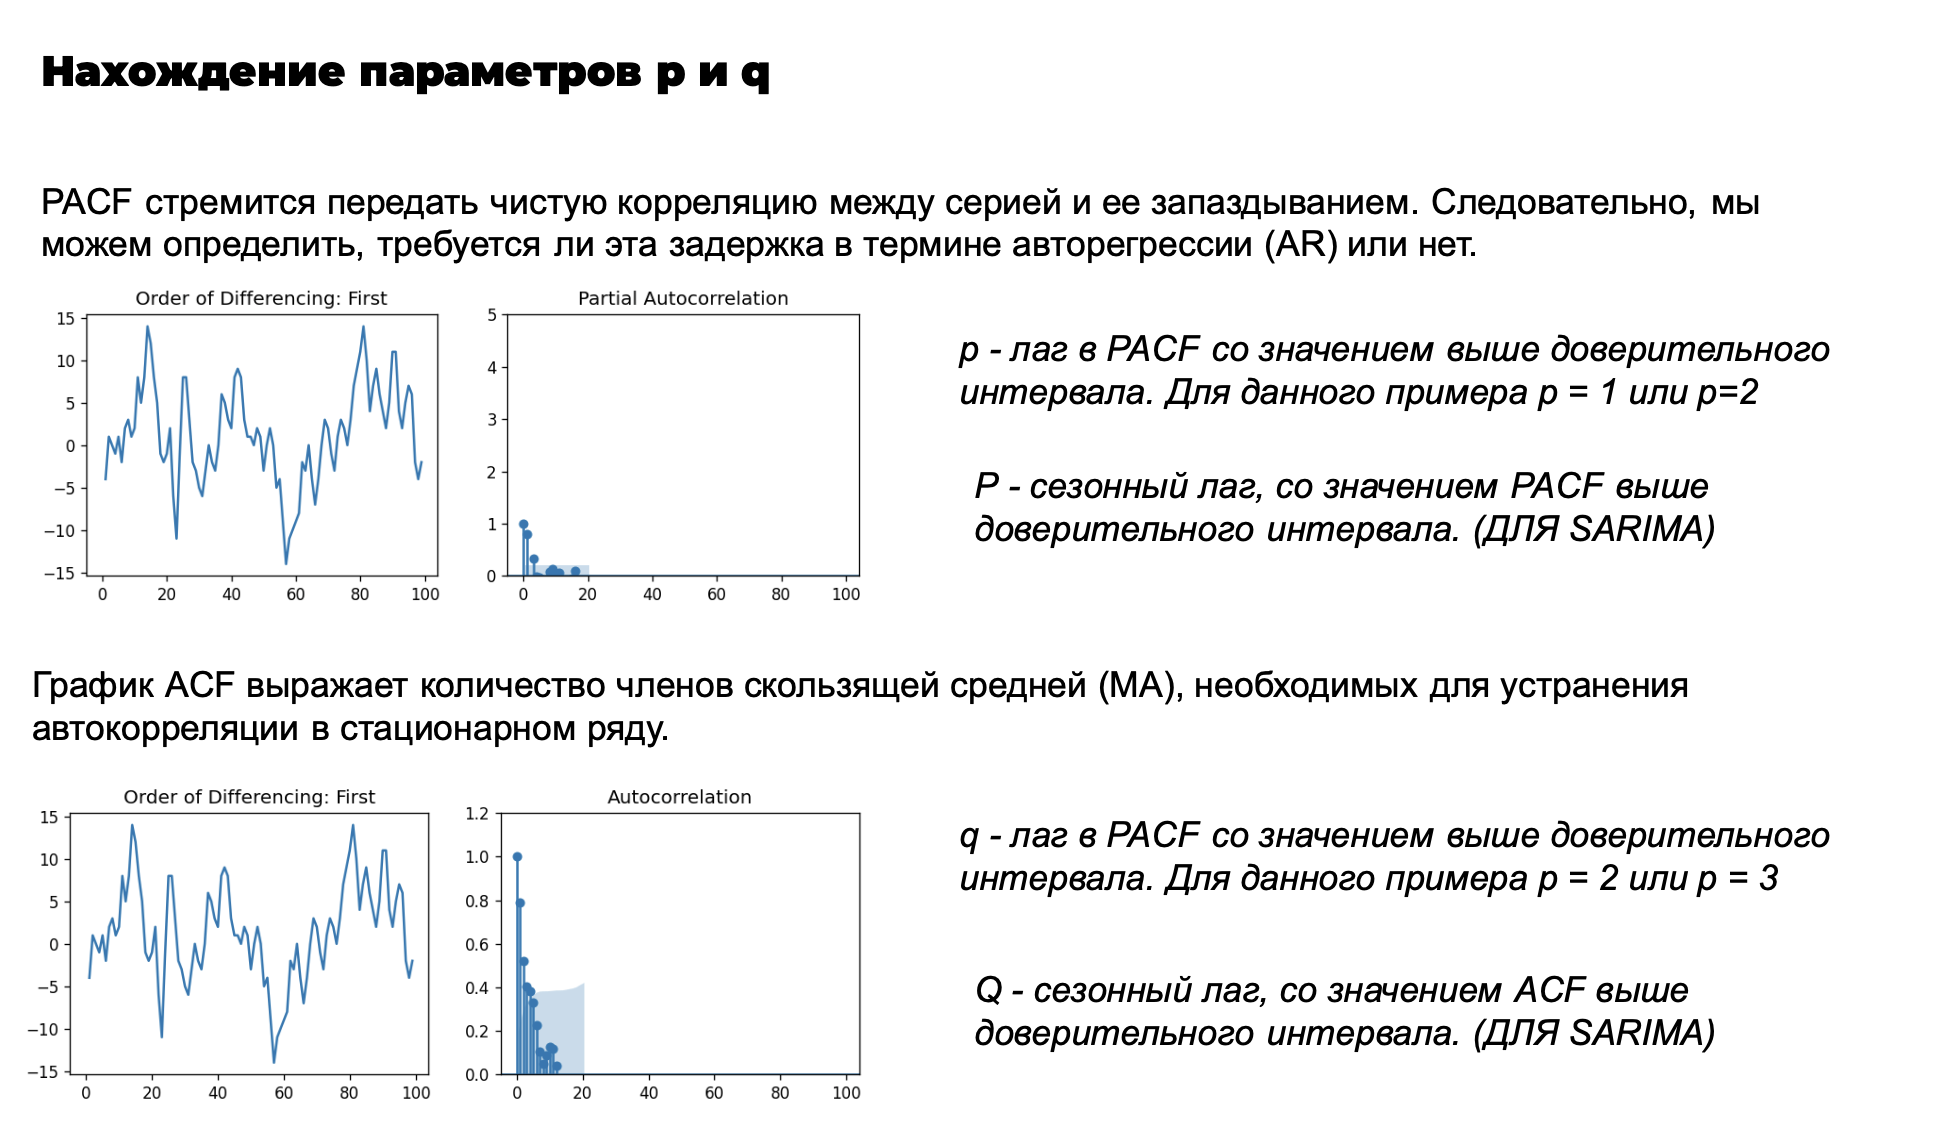

In [ ]:

%pylab inline
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:

original = pd.read_csv(
    "/content/drive/My Drive/HW_AdvancedML/SMLT_ITMO_01/daily_temp.csv",
    parse_dates=['Date'],
    dayfirst=True,
    encoding='cp1251'
)


original['normed'] = (original['Temp'] - original['Temp'].min())/(original['Temp'].max() - original['Temp'].min())
original.head()

data = original[:-600]

idx = pd.date_range(data['Date'][0], periods=data['Date'].shape[0], freq='D')
ts = pd.Series(data['normed'].values, index=idx)

print(ts)

1981-01-01    0.787072
1981-01-02    0.680608
1981-01-03    0.714829
1981-01-04    0.555133
1981-01-05    0.600760
                ...   
1989-05-04    0.391635
1989-05-05    0.410646
1989-05-06    0.399240
1989-05-07    0.361217
1989-05-08    0.475285
Freq: D, Length: 3050, dtype: float64


In [ ]:
data.head(10)

,Date,Temp,normed
0,1981-01-01,20.7,0.787072
1,1981-01-02,17.9,0.680608
2,1981-01-03,18.8,0.714829
3,1981-01-04,14.6,0.555133
4,1981-01-05,15.8,0.600760
5,1981-01-06,15.8,0.600760
6,1981-01-07,15.8,0.600760
7,1981-01-08,17.4,0.661597
8,1981-01-09,21.8,0.828897
9,1981-01-10,20.0,0.760456


In [ ]:
result = sm.tsa.seasonal_decompose(ts)

# result.plot()

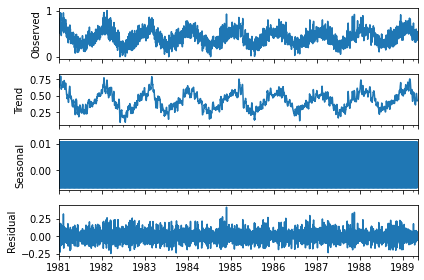

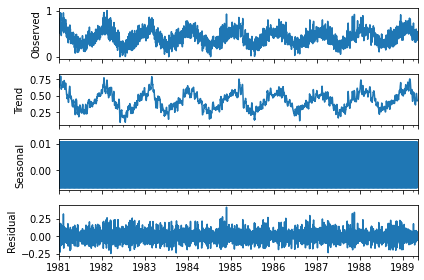

In [ ]:
result.plot()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Best Box-Cox parameter: 0.466944
Dickey-Fuller test: p=0.000660


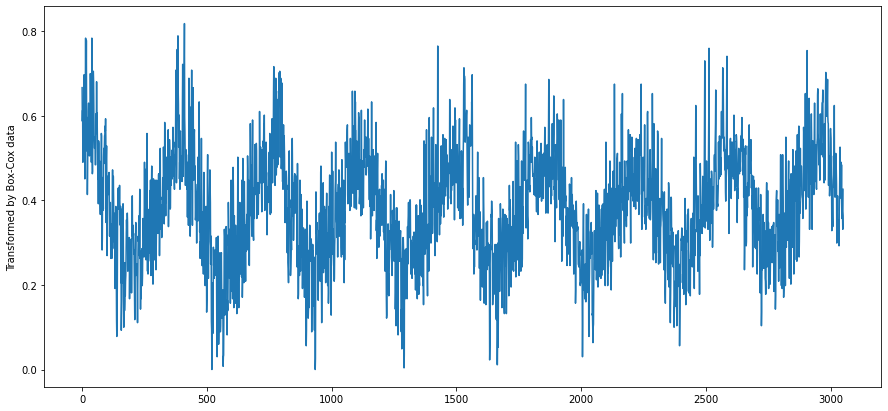

In [ ]:

data['box'], lmbda = stats.boxcox(ts+1)
plt.figure(figsize(15,7))
data.box.plot()
plt.ylabel('Transformed by Box-Cox data')
print("Best Box-Cox parameter: %f" % lmbda)
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(data.box)[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Dickey-Fuller test: p=0.006229425753584


<Figure size 1080x720 with 0 Axes>

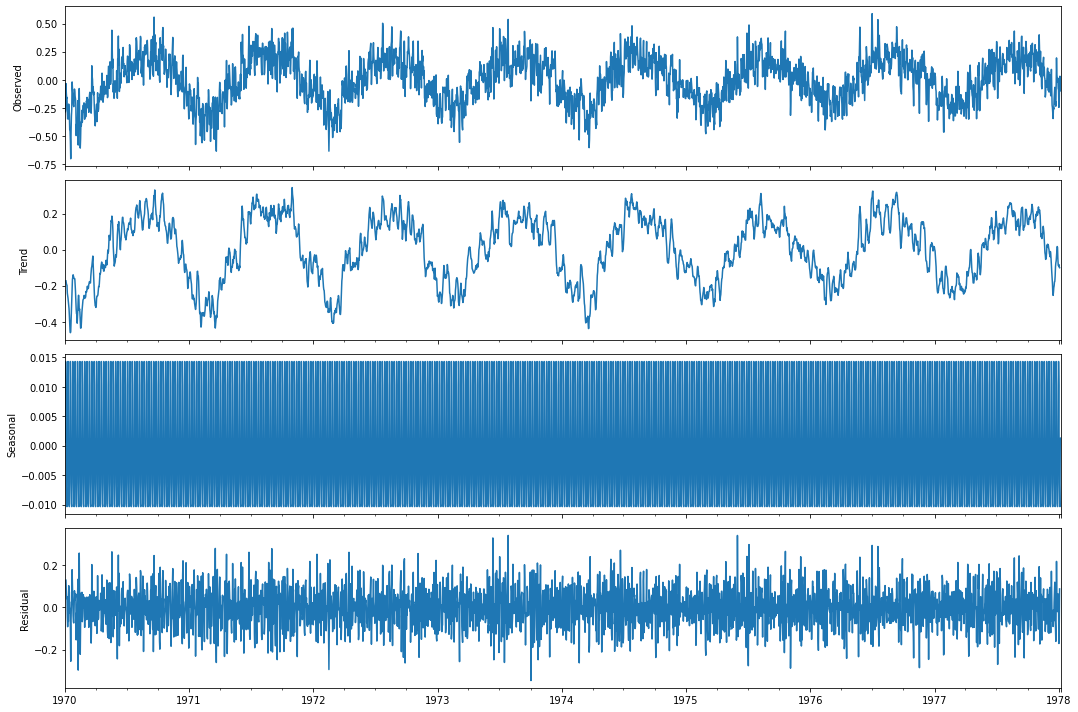

In [ ]:
data['shifted'] = data.box - data.box.shift(122)
idx = pd.date_range(data['box'][122], periods=data['box'][122:].shape[0], freq='D')
ts_shifted = pd.Series(data['shifted'].values[122:], idx)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(ts_shifted).plot()
print("Dickey-Fuller test: p=%.15f" % sm.tsa.stattools.adfuller(ts_shifted)[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Dickey-Fuller test: p=0.000000000000000


<Figure size 1080x720 with 0 Axes>

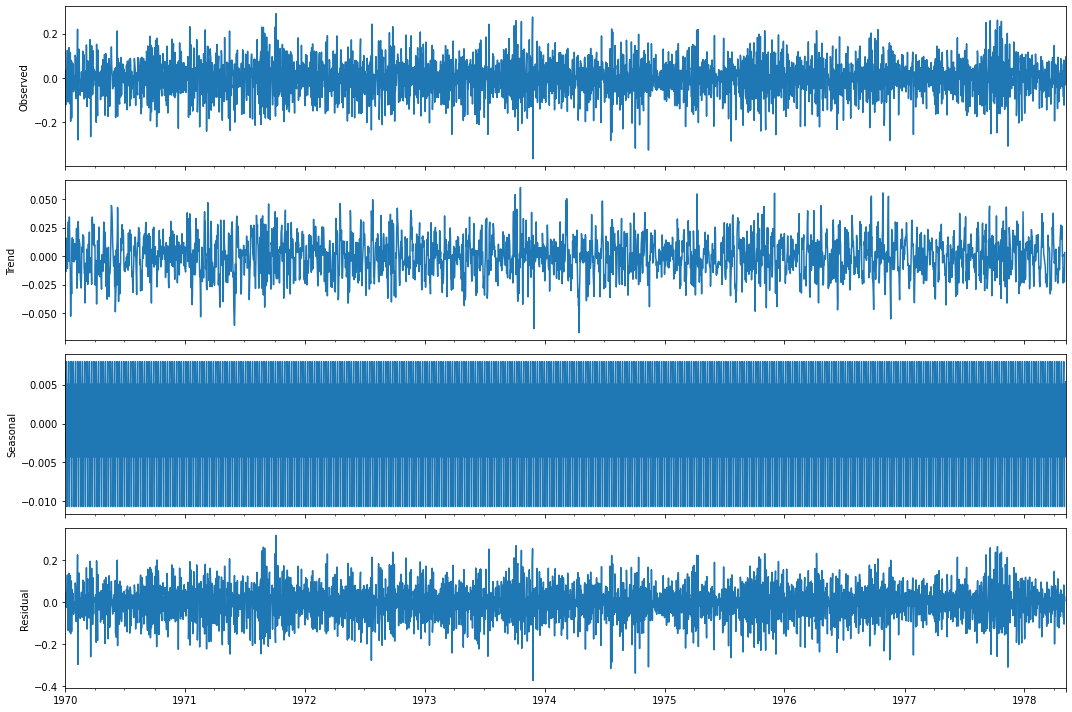

In [ ]:
data['shifted_2'] = data.box - data.box.shift(1)
idx = pd.date_range(data['box'][122], periods=data['box'][1:].shape[0], freq='D')
ts_shifted_2 = pd.Series(data['shifted_2'].values[1:], idx)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(ts_shifted_2).plot()
print("Dickey-Fuller test: p=%.15f" % sm.tsa.stattools.adfuller(ts_shifted_2)[1])

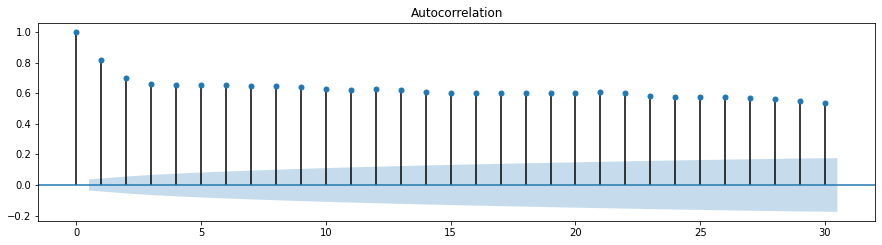

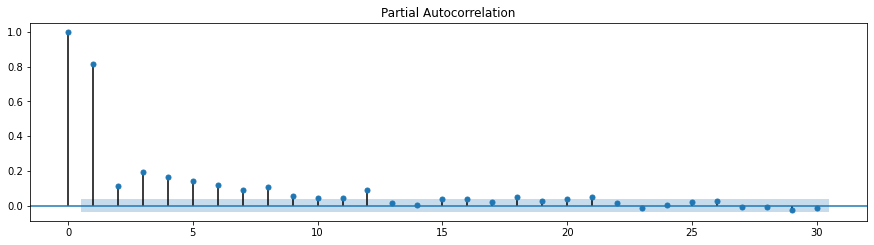

In [ ]:

plt.figure(figsize(15,8))

# autocorrelation
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.shifted[123:].values.squeeze(), lags=30, ax=ax)
pylab.show()

# partial autocorrelation
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.shifted[123:].values.squeeze(), lags=30, ax=ax)
pylab.show()


In [ ]:

ps = range(0, 6)
d=1
qs = range(0, 6)
Ps = range(0, 2)
D=1
Qs= range(0,1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print ("Number of analysed models:", len(parameters_list))

Number of analysed models: 72


In [ ]:
results = []
best_aic = float("inf")

# ignore warnings
warnings.filterwarnings('ignore')

for param in parameters_list:

    #try except for the case of wrong parameters
    try:
        model=sm.tsa.statespace.SARIMAX(data.box, order=(param[0], d, param[1]),
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)

    #print wrong parameters and go on
    # AIC criteria:
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    #print(aic)

    # save best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
        results.append([param, model.aic])
        #print(results)
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda*y + 1)/lmbda)

     parameters          aic
9  (5, 5, 1, 0) -5836.402286
8  (3, 2, 1, 0) -5828.186937
7  (2, 4, 1, 0) -5809.027366
6  (1, 2, 1, 0) -5756.696497
5  (0, 4, 1, 0) -5752.641327


In [ ]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters          aic
9  (5, 5, 1, 0) -5836.402286
8  (3, 2, 1, 0) -5828.186937
7  (2, 4, 1, 0) -5809.027366
6  (1, 2, 1, 0) -5756.696497
5  (0, 4, 1, 0) -5752.641327


In [ ]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                box   No. Observations:                 3050
Model:             SARIMAX(5, 1, 5)x(1, 1, 0, 12)   Log Likelihood                2930.201
Date:                            Wed, 22 Dec 2021   AIC                          -5836.402
Time:                                    12:45:30   BIC                          -5764.179
Sample:                                         0   HQIC                         -5810.440
                                           - 3050                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0024      0.051    -19.642      0.000      -1.102      -0.902
ar.L2         -0.9052      0.063   

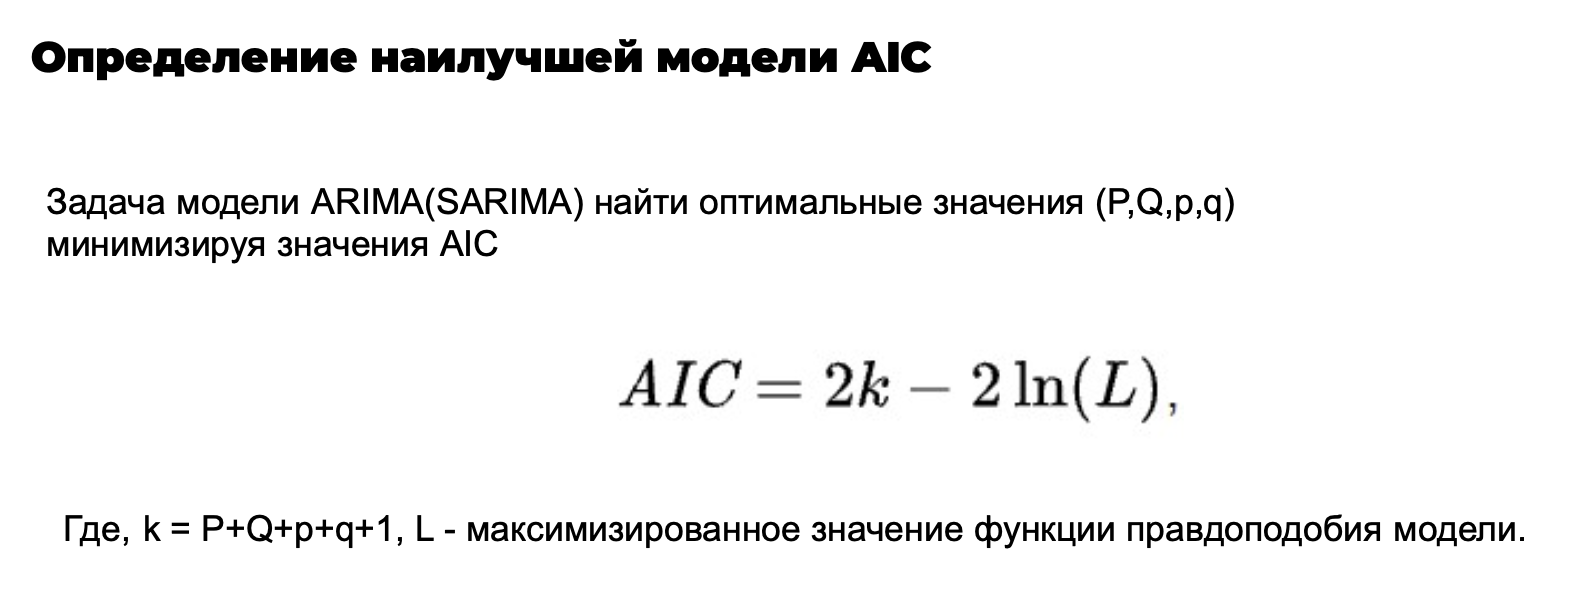

Student test: p=0.237977
Dickey-Fuller test: p=0.0000000000000022527271352


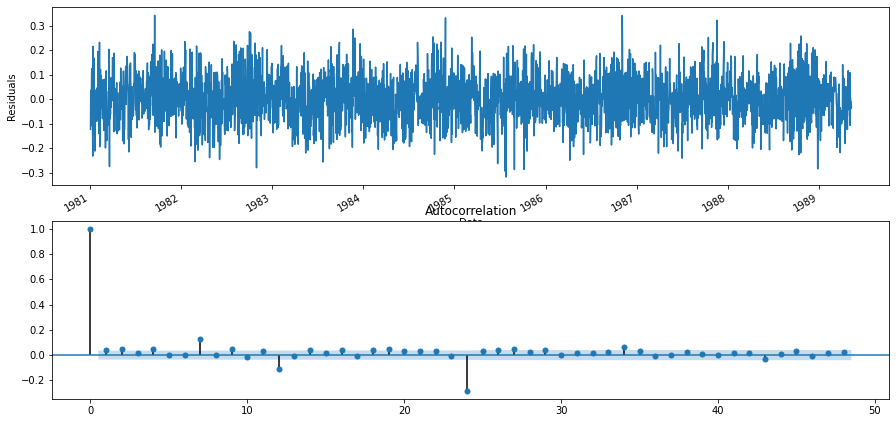

In [ ]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[3:].plot()
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[3:].values.squeeze(), lags=48, ax=ax)

print("Student test: p=%f" % stats.ttest_1samp(best_model.resid[3:], 0)[1])
print("Dickey-Fuller test: p=%.25f" % sm.tsa.stattools.adfuller(best_model.resid[3:])[1])

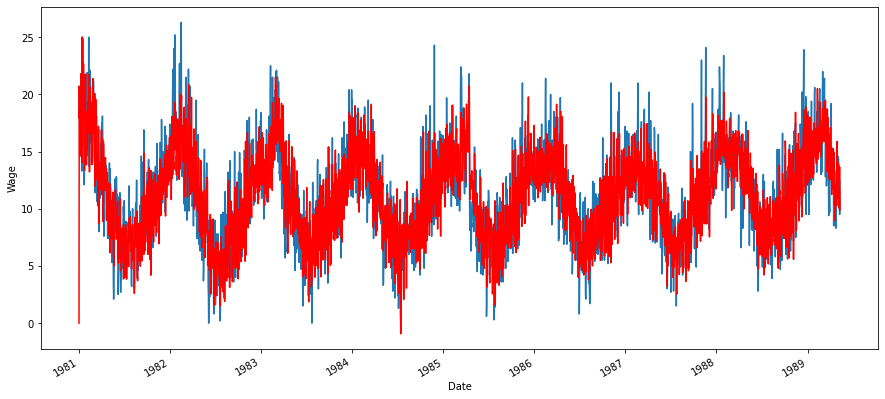

In [ ]:
def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda*y + 1)/lmbda)

data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
model = (data['model']-1)*(data.Temp.max() - data.Temp.min()) + data.Temp.min()
# shift = (data['shifted_2'])*(data.Temp.max() - data.Temp.min()) + data.Temp.min()
data.Temp.plot()
model[:].plot(color='r')
plt.ylabel('Wage')
pylab.show()


In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error

MAPE:  0.2029461539526506
R squere:  0.3872154848089221


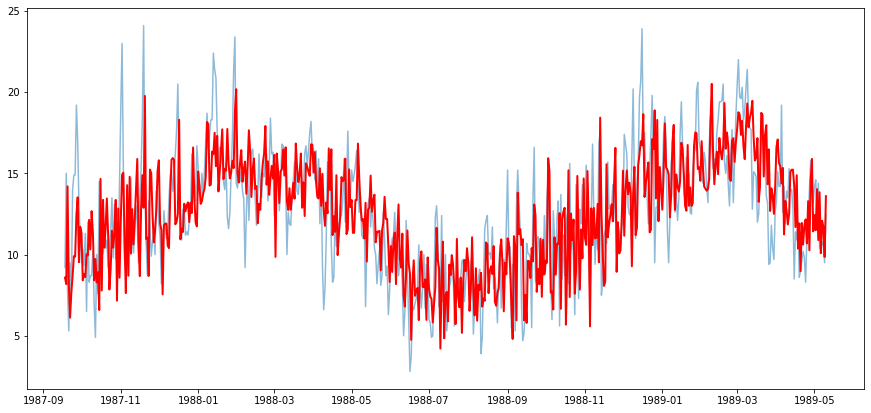

In [ ]:
plt.plot(data.Temp[-600:], alpha = 0.5)
plt.plot(model[-600:], color='r',linewidth=2)

print("MAPE: ", mean_absolute_percentage_error(data.Temp[-600:],model[-600:]))
print("R squere: ", r2_score(data.Temp[-600:], model[-600:]))

LSTM MODEL PARAMETRS:   *mape = 0.36, R squere = 0.18*

ARIMA MODEL PARAMETRS:  *mape = 0.20, R squere = 0.38*

**ARIMA model is better for timeseries daily_temp.csv**